За основу была взята данная статья: https://www.tensorflow.org/tutorials/images/classification

Kaggle Team: Dmitry_Sokolov_16033706

Score: 0.98299

Копипаст из колаб, мб где-то ошибки

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization

In [12]:
from tensorflow_addons.optimizers import AdamW

In [30]:
import pathlib
data_dir = pathlib.Path('../input/journey-springfield/train/simpsons_dataset')
test_dir = pathlib.Path('../input/journey-springfield/testset')

In [31]:
# Количество тестовых изображений # Не работает :(
from os import listdir
from os.path import isfile, join
onlyfiles = [f for f in listdir(test_dir) if isfile(join(test_dir, f))]
len(onlyfiles)

0

In [21]:
# Количество тренировочных изображений
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

20933


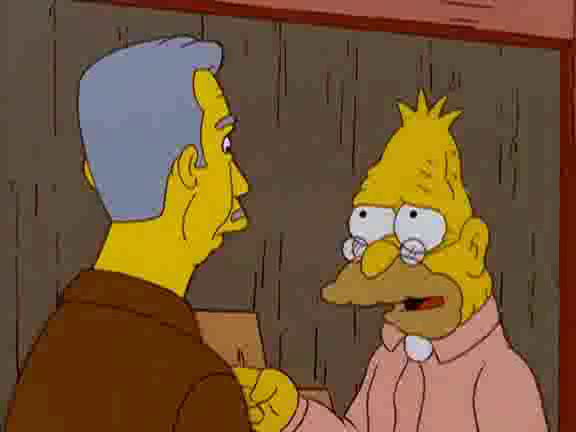

In [22]:
abraham_grampa_simpson = list(data_dir.glob('abraham_grampa_simpson/*'))
PIL.Image.open(str(abraham_grampa_simpson[0]))

In [23]:
batch_size = 256
img_height = 128 # Colab при использовании TensofFlow крашится из-за нехватки RAM, если использовать изображения 224*224
img_width = 128

In [24]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 20933 files belonging to 42 classes.
Using 16747 files for training.


In [25]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 20933 files belonging to 42 classes.
Using 4186 files for validation.


In [26]:
class_names = train_ds.class_names
print(class_names)

['abraham_grampa_simpson', 'agnes_skinner', 'apu_nahasapeemapetilon', 'barney_gumble', 'bart_simpson', 'carl_carlson', 'charles_montgomery_burns', 'chief_wiggum', 'cletus_spuckler', 'comic_book_guy', 'disco_stu', 'edna_krabappel', 'fat_tony', 'gil', 'groundskeeper_willie', 'homer_simpson', 'kent_brockman', 'krusty_the_clown', 'lenny_leonard', 'lionel_hutz', 'lisa_simpson', 'maggie_simpson', 'marge_simpson', 'martin_prince', 'mayor_quimby', 'milhouse_van_houten', 'miss_hoover', 'moe_szyslak', 'ned_flanders', 'nelson_muntz', 'otto_mann', 'patty_bouvier', 'principal_skinner', 'professor_john_frink', 'rainier_wolfcastle', 'ralph_wiggum', 'selma_bouvier', 'sideshow_bob', 'sideshow_mel', 'snake_jailbird', 'troy_mcclure', 'waylon_smithers']


In [32]:
number_of_images = len(onlyfiles)
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  test_dir,
  label_mode=None,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  shuffle=False)

Found 991 files belonging to 1 classes.


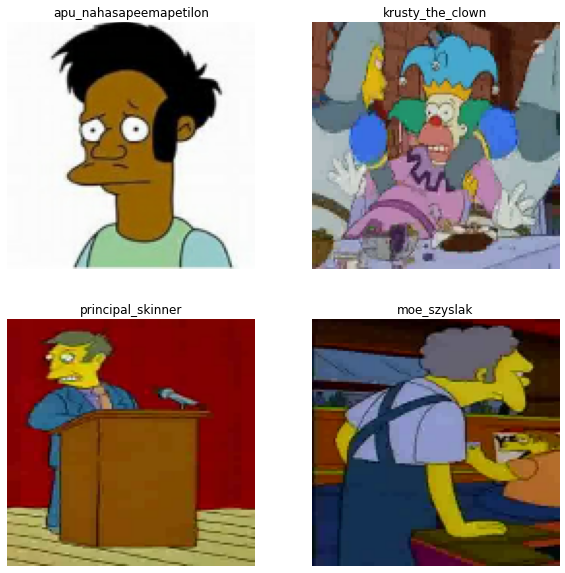

In [33]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(4):
    ax = plt.subplot(2, 2, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [34]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(256, 128, 128, 3)
(256,)


In [35]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Аугментация

In [36]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

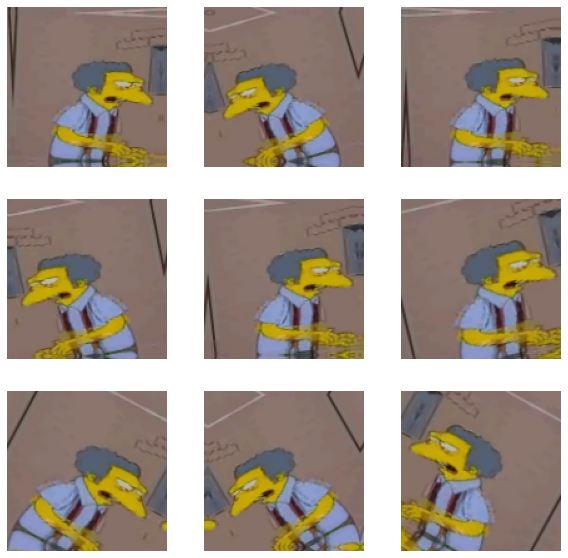

In [37]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [38]:
num_classes = 42

Модель:

Добавил BatchNormalization и дополнительный Dropout, поменял оптимайзер на AdamW

In [39]:
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dropout(0.2),
  layers.Dense(num_classes)
])

In [40]:
adam_w = AdamW(weight_decay=1e-6)

Добавим F1 метрику (почему-то работает некорректно)

In [41]:
from tensorflow_addons.metrics import F1Score
f1_score = F1Score(num_classes,average="micro",threshold=0.9)

In [42]:
model.compile(optimizer=adam_w,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy', f1_score])

In [43]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 128, 128, 3)       0         
_________________________________________________________________
rescaling (Rescaling)        (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 128, 16)      448       
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 128, 16)      64        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 32)       

In [44]:
checkpoint_path = './checkpoints/simpsons_cnn_tf_cp' # colab не отображает файлы почему-то :(
# checkpoint_path = '/content/gdrive/MyDrive/checkpoints/simpsons_cnn_tf_cp'

In [45]:
# Загружаем сохранненные веса модели (если сохраняли из раньше)
# model.load_weights(checkpoint_path)

In [46]:
epochs = 320 # 180 is enough for 0.97874 # and after 320 I got 0.98299 
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/320


KeyboardInterrupt: 

In [47]:
# проверим точность на валидационной части
# loss, acc = model.evaluate(val_ds, verbose=2)
# print("accuracy: {:5.2f}%".format(100 * acc))

# eval_r = model.evaluate(val_ds, verbose=2)
# print(eval_r)

In [49]:
model.save_weights(checkpoint_path)
!ls ./checkpoints/

checkpoint  simpsons_cnn_tf_cp.data-00000-of-00001  simpsons_cnn_tf_cp.index


In [50]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

NameError: name 'history' is not defined

In [51]:
image_batch = test_ds.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)

for i in range (batch_size):
  score = tf.nn.softmax(predictions[i])
  print(
    "class: {} with a {:.2f} confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
    )
  
predictions_ = [np.argmax(tf.nn.softmax(i)) for i in predictions]

class: homer_simpson with a 11.62 confidence.
class: homer_simpson with a 6.64 confidence.
class: homer_simpson with a 9.50 confidence.
class: homer_simpson with a 7.93 confidence.
class: homer_simpson with a 11.55 confidence.
class: homer_simpson with a 7.28 confidence.
class: homer_simpson with a 7.53 confidence.
class: homer_simpson with a 8.45 confidence.
class: homer_simpson with a 11.83 confidence.
class: homer_simpson with a 7.79 confidence.
class: homer_simpson with a 7.25 confidence.
class: homer_simpson with a 8.24 confidence.
class: homer_simpson with a 10.51 confidence.
class: homer_simpson with a 7.97 confidence.
class: homer_simpson with a 4.04 confidence.
class: homer_simpson with a 8.56 confidence.
class: homer_simpson with a 7.44 confidence.
class: homer_simpson with a 5.87 confidence.
class: homer_simpson with a 10.08 confidence.
class: homer_simpson with a 9.33 confidence.
class: homer_simpson with a 11.03 confidence.
class: homer_simpson with a 8.53 confidence.
clas

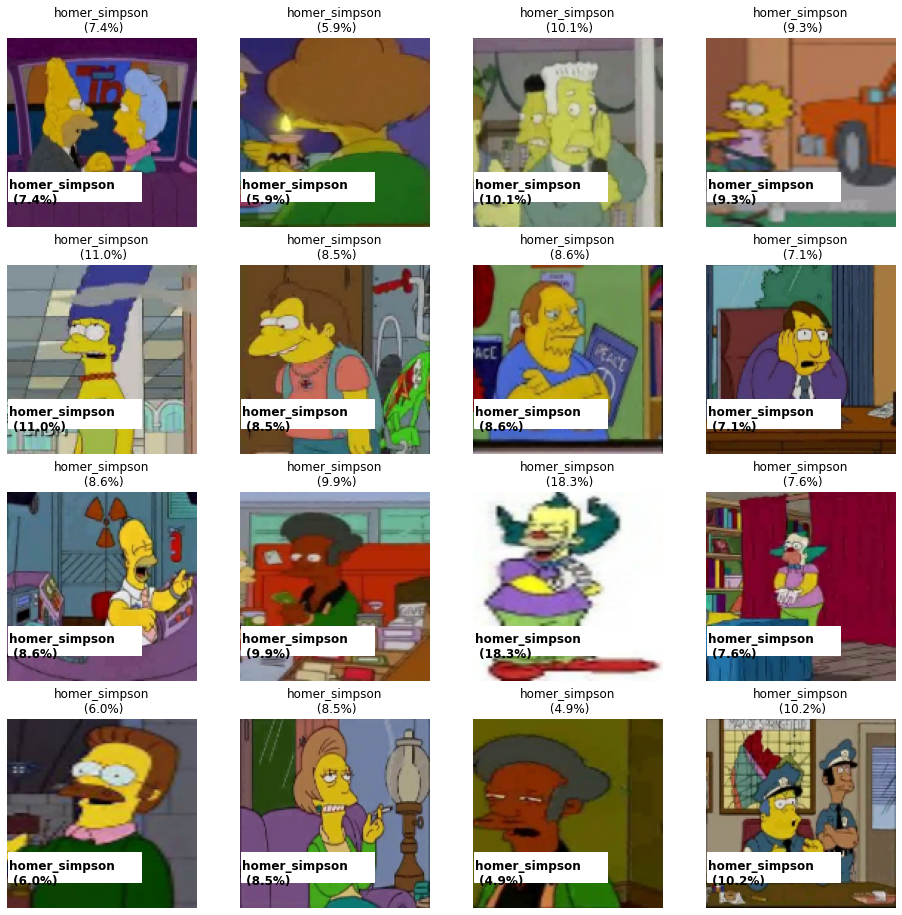

In [52]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

font = FontProperties()
font.set_family("fantasy")

NUMBER_FOR_SHIFT = 16 # Для того, чтобы выбирать разные картинки из батча

plt.figure(figsize=(16, 16))
for i in range(16):
  ax = plt.subplot(4, 4, i + 1)
  plt.imshow(image_batch[i+NUMBER_FOR_SHIFT].astype("uint8"))
  conf_str = "{:.1f}".format(100 * np.max(tf.nn.softmax(predictions[i+NUMBER_FOR_SHIFT])))

  ax.add_patch(patches.Rectangle((0, 90),90,20,color='white'))
  ax.text(1, 95,class_names[predictions_[i+NUMBER_FOR_SHIFT]] + '\n ('+ conf_str +'%)', horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=12, color='black',fontweight='bold')

  plt.title(class_names[predictions_[i+NUMBER_FOR_SHIFT]] + '\n ('+ conf_str +'%)')
  plt.axis("off")

In [53]:
predicted = []
for image_batch in test_ds:
  predicted_batch = model.predict(image_batch)
  predicted_id = np.argmax(predicted_batch, axis=-1)
  predicted_label_batch = []
  for id in predicted_id:
    predicted_label_batch.append(class_names[id])
  predicted.append(predicted_label_batch)

In [54]:
from pandas.core.common import flatten # список списков в одномерный список
predicted = list(flatten(predicted))

In [57]:
test_files = sorted(list(test_dir.glob('*/*.jpg'))) # получаем имена файлов тестовых картинок
test_files = [item.name for item in test_files]

In [61]:
my_submit = pd.DataFrame({'Id': test_files, 'Expected': predicted})
my_submit.to_csv('simple_cnn_tf.csv', index=False)
my_submit.head(5)

,Id,Expected
0,img0.jpg,homer_simpson
1,img1.jpg,homer_simpson
2,img10.jpg,homer_simpson
3,img100.jpg,homer_simpson
4,img101.jpg,homer_simpson
